In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim


In [20]:
torch.manual_seed(42)
np.random.seed(42)
t = torch.linspace(0, 60, 120)
dt = t[1] - t[0]
print(dt)

tensor(0.5042)


/var/folders/st/2jlnq0ld019_1m1pwbr32slh0000gn/T/ipykernel_38611/2017428981.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  curve = 2.0 * ((t - 5)/4)**2 * np.exp(-(t - 5)/8) * (t >= 5)
/var/folders/st/2jlnq0ld019_1m1pwbr32slh0000gn/T/ipykernel_38611/2017428981.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return A * np.exp(-t/width)


Text(0.5, 1.0, 'Fermi Function')

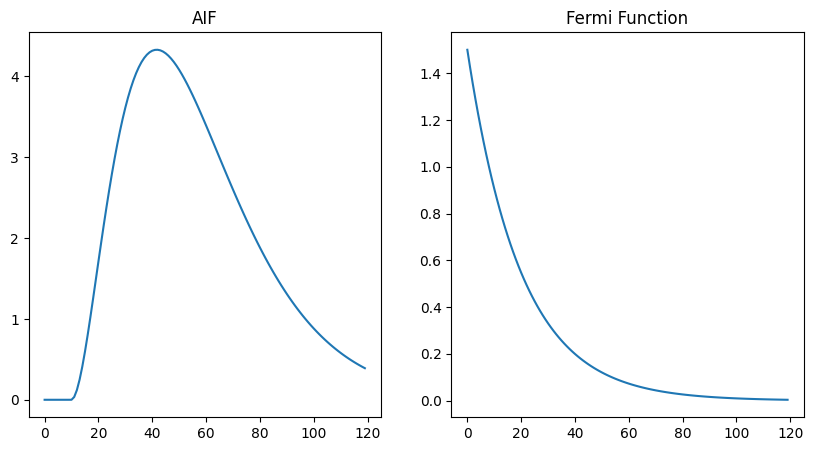

In [30]:
def simple_aif(t):
    # a simple quadratic curve
    curve = 2.0 * ((t - 5)/4)**2 * np.exp(-(t - 5)/8) * (t >= 5)
    return curve

def simple_fermi(t, A, width):
    return A * np.exp(-t/width)

# ml/min/g
true_MBF = 1.5  
true_width = 10.0

aif = simple_aif(t)
true_impulse = simple_fermi(t, true_MBF, true_width)


plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(aif)
plt.title("AIF")
plt.subplot(122)
plt.plot(true_impulse)
plt.title("Fermi Function")

<class 'torch.Tensor'> <class 'torch.Tensor'>


Text(0.5, 1.0, 'Real (noisy) tissue curve')

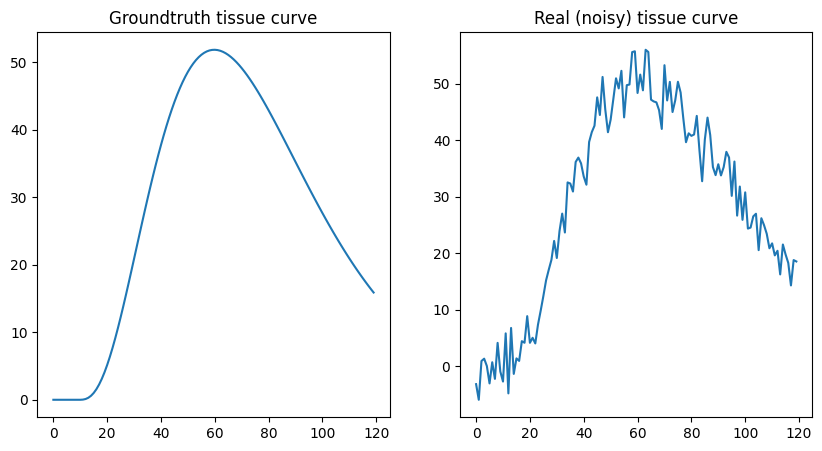

In [29]:
def convolve(signal1, signal2, dt):
    print(type(signal1), type(signal2))
    conv = np.convolve(signal1, signal2)*dt.numpy()
    return conv[:len(signal1)]
tissue_curve = torch.tensor(convolve(aif, true_impulse, dt))

real_tissue_curve = tissue_curve + torch.randn(len(aif))*3
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(tissue_curve)
plt.title("Groundtruth tissue curve")
plt.subplot(122)
plt.plot(real_tissue_curve)
plt.title("Real (noisy) tissue curve")

In [39]:
class DeconvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.A = nn.Parameter(torch.tensor(0.5))
        self.width = nn.Parameter(torch.tensor(5.0))
        
    def forward(self, aif, t):
        tf =  self.A * torch.exp(-t/self.width)
        result = torch.zeros_like(aif)
        for i in range(len(aif)):
            for j in range(i+1):
                result[i] += aif[j] * tf[i-j]
        return result * dt

In [42]:
model = DeconvModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    tissue_response = model(aif, t)
    loss = criterion(tissue_response, real_tissue_curve)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Loss: {loss.item()}")

Loss: 761.4552001953125
Loss: 688.9766845703125
Loss: 618.3954467773438
Loss: 550.3178100585938
Loss: 485.32470703125
Loss: 423.9540100097656
Loss: 366.6855773925781
Loss: 313.9251708984375
Loss: 265.98773193359375
Loss: 223.0809783935547


In [49]:
pred_A, pred_w = model.state_dict()["A"], model.state_dict()["width"]

In [50]:
pred_impulse = simple_fermi(t, pred_A, pred_w)

/var/folders/st/2jlnq0ld019_1m1pwbr32slh0000gn/T/ipykernel_38611/2017428981.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return A * np.exp(-t/width)


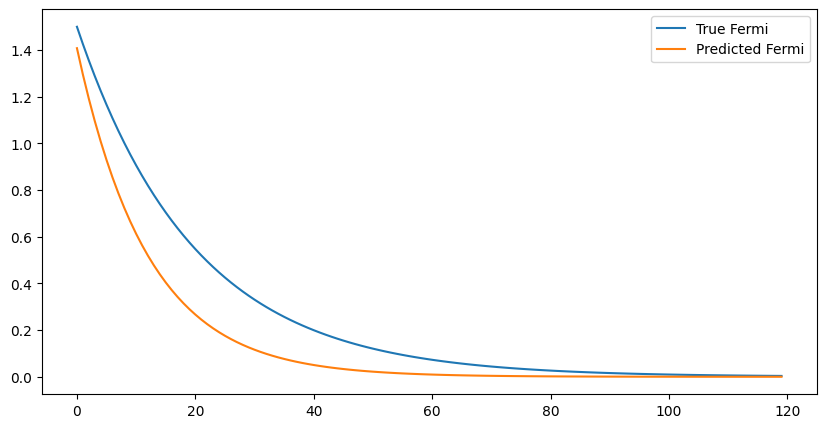

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(true_impulse, label="True Fermi")
plt.plot(pred_impulse, label="Predicted Fermi")
plt.legend()